# 1. Handling imports

In [ ]:
import sys
import os

# Add 'predrnn' to sys.path so imports like 'from core...' work
project_root = os.path.abspath("predrnn")  # or use full path if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)



# PyTorch (related) imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else "cpu")
device = 'cpu'
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import time

from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import clear_output

# Custom imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel, architectures

# predrnn imports
from predrnn.core.models.predrnn_v2 import RNN as PredRNN
from predrnn.configparser import build_predrnn_args
from predrnn.core.data_provider import datasets_factory

import lpips as lpips_lib
from predrnn.core.utils import metrics, preprocess
from skimage.metrics import structural_similarity as compare_ssim

# for reproducibility
np.random.seed(42)


Torch device: cpu


# 2. handling file paths

In [3]:
autoencoder_root_path = Path("autoencoder") / "models"
predrnn_root_path = Path("predrnn") / "checkpoints"
predrnn_base_data_dir = Path("dataset")

# 3. Loading the trained models
## A. Autoencoders

In [4]:
def load_autoencoder(latent_dimension: int, source_dir: Path) -> AutoencoderModel:
    """Fetches the trained autoencoder with given latent dimension.

    Args:
        latent_dimension (int): The latent dimension the encoder reduces the inputs into
        source_dir (Path): A Path to the directory in which the autoencoders are saved
        
    Returns:
        AutoencoderModel: The loaded autoencoder

    """
    architecture_mapping = {
        64: 1,
        32: 2,
        16: 3
    }
    architecture = architectures[architecture_mapping[latent_dimension]]
    
    best_trial = {
        64: "model_trial_2_1.pt",
        32: "model_trial_1_2.pt",
        16: "model_trial_0_3.pt"
    }
    
    autoencoder =  AutoencoderModel(epochs=200, encoder=architecture["encoder"], decoder=architecture["decoder"]).to(device)
    autoencoder.load(source_dir / best_trial[latent_dimension], device=device)
    autoencoder.eval()
    
    return autoencoder

# autencoder_64 = load_autoencoder(64, autoencoder_root_path) # 64x64 autencoder
# autencoder_32 = load_autoencoder(32, autoencoder_root_path) # 32x32 autencoder
# autencoder_16 = load_autoencoder(16, autoencoder_root_path) # 16x16 autencoder


## B. PredRNN

In [5]:
from predrnn.core.models.model_factory import Model as PredRNNModel

def load_predRNN(latent_dimension: int, predrnn_dir: Path, data_dir: Path) -> PredRNN:
    """Loads a trained PredRNN network.

    Args:
        latent_dimension (int): When given, the network that takes in the provided latent_dimension will be loaded. 
        None results in the vanilla network without autoencoder preprocessing.
        predrnn_dir (Path): Path to the base directory in which the different PredRNN models are stored.
        data_dir (Path): Path to the base directory in which the different datasets are stored.
        

    Returns:
        PredRNN: The loaded network.
        
    """
    best_model = {
        16: 'best.model',
        32: 'best.model',
        64: 'best.model'
    }
    
    # Load vanilla model if no latent dimension is given
    if latent_dimension is None:
        # Hard coded Vanilla configs
        configs = build_predrnn_args(img_width=128, 
                                    data_dir=str((data_dir / 'kth').resolve()), 
                                    result_checkpoint_dir='kth_predrnn_vanilla')
        predRNN = PredRNNModel(configs)
        predRNN.load(str((predrnn_dir / "kth_predrnn_vanilla" / "best.model").resolve()))
        
    else:
        # Dynamic loading of latent model based on latent dimension
        configs = build_predrnn_args(img_width=latent_dimension, 
                                    data_dir=str((data_dir / 'encoded' / str(latent_dimension)).resolve()), 
                                    result_checkpoint_dir=f'kth_predrnn_{latent_dimension}')
        predRNN = PredRNNModel(configs)
        predRNN.load(str((predrnn_dir / f"kth_predrnn_{latent_dimension}" / best_model[latent_dimension]).resolve()))
        
    return predRNN

# predrnn_native = load_predRNN(None, predrnn_root_path, predrnn_base_data_dir) # 128x128 (native) predRNN model
# predrnn_64 = load_predRNN(64, predrnn_root_path, predrnn_base_data_dir)       # 64x64 PredRNN
# predrnn_32 = load_predRNN(32, predrnn_root_path, predrnn_base_data_dir)       # 32x32 PredRNN
# predrnn_16 = load_predRNN(16, predrnn_root_path, predrnn_base_data_dir)       # 16x16 PredRNN


## 4. Load test dataset

In [6]:
def load_test_dataset(latent_dimension: int, data_dir: Path):
    """_summary_

    Args:
        latent_dimension (int): The size of the latent dimension of the associated autoencoder. The images are of size (latent_dimension, latent_dimension).
        None indicated no autoencoder is used and the images are the standard (128,128).
        data_dir (Path): A Path to the directory in which the datasets are stored.

    Returns:
        InputHandle: The InputHandle (see data_provider package) with the test data.
    """
    if latent_dimension is None:
        dataset_name = 'action'
        data_path = str((data_dir / 'kth').resolve())
        img_width = 128
    else:
        dataset_name = 'latent'
        data_path = str((data_dir / 'encoded' / str(latent_dimension)).resolve())
        img_width = latent_dimension
        
    test_input_handle = datasets_factory.data_provider(
            dataset_name=dataset_name, 
            train_data_paths=data_path, 
            valid_data_paths=data_path, 
            batch_size=4, 
            img_width=img_width,
            seq_length=20, 
            injection_action='concat', 
            is_training=False)
    return test_input_handle

# test_data_16 = load_test_dataset(16, predrnn_base_data_dir)

## 5. Testing the model

In [7]:
latent_size = 16

# Training Params #
img_width = latent_size
img_channel = 1
patch_size = 4
batch_size = 4
total_length = 20
input_length = 10
# # # # # # # # # #

### 5.1 Compare images

In [ ]:

def get_predictions(predRNNModel: PredRNNModel, autoencoderModel: AutoencoderModel, test_ims, latent_dimension: int):
    """Performs inference on the given batch and returns the results.

    Args:
        predRNNModel (PredRNNModel): the trained predRNN model
        autoencoderModel (AutoencoderModel): the trained autoencoder model
        test_ims (np.ndarray): the test batch to use for predictions
        latent_dimension (int): the latent dimension used by the autoencoder and predRNN. Is ignored if no autoencoder is present (Vanilla model)

    Returns:
        dict: A dictionary with the inputs, vanilla 
    """
    # Reverse schedule sampling #
    mask_input = 1

    real_input_flag = np.zeros(
        (batch_size,
            total_length - mask_input - 1,
            img_width // patch_size,
            img_width // patch_size,
            patch_size ** 2 * img_channel))

    real_input_flag[:, :input_length - 1, :, :] = 1.0

    input = test_ims
    if autoencoderModel is not None:
        # Encode #
        reshaped_test_ims = test_ims.reshape(batch_size, total_length, 1, 128, 128)
        reshaped_test_ims = torch.from_numpy(reshaped_test_ims)

        encoded_test_ims = torch.stack(list(autoencoderModel.encode(sequence) for sequence in reshaped_test_ims))
        encoded_test_ims = encoded_test_ims.detach().numpy().reshape(batch_size, total_length, latent_dimension, latent_dimension, 1)
        input = encoded_test_ims
    
    # Patch
    test_dat = preprocess.reshape_patch(input, patch_size)
    test_ims = test_ims[:, :, :, :, :img_channel]
    
    # Forwards
    img_gen = predRNNModel.test(test_dat, real_input_flag)
    
    # De-patch
    img_gen = preprocess.reshape_patch_back(img_gen, patch_size)
    
    output = img_gen
    if autoencoderModel is not None:
        # Decode #
        img_gen_reshaped = img_gen.reshape(batch_size, total_length-1, 1, latent_dimension, latent_dimension)
        img_gen_reshaped = torch.from_numpy(img_gen_reshaped)

        decoded_img_gen = torch.stack(list(autoencoderModel.decode(sequence) for sequence in img_gen_reshaped))
        decoded_img_gen = decoded_img_gen.detach().numpy().reshape(batch_size, total_length-1, 128, 128, 1)
        output = decoded_img_gen

    output_length = total_length - input_length 
    img_out = output[:, -output_length:]
    
    return output, img_out

In [11]:
test_handle = load_test_dataset(None, predrnn_base_data_dir)
input = test_handle.get_batch()

images = {
    'input': input[0][:10]
}

# Test Vanilla #
img_width = 128

predrnn = load_predRNN(None, predrnn_root_path, predrnn_base_data_dir)

output, predictions = get_predictions(predrnn, None, input, None)
images['vanilla'] = predictions[0]

# Test Latent models #
for latent in [16, 32, 64]:
    img_width = latent

    autoencoder = load_autoencoder(latent, autoencoder_root_path)
    predrnn = load_predRNN(latent, predrnn_root_path, predrnn_base_data_dir)
    
    output, predictions = get_predictions(predrnn, autoencoder, input, latent)
    
    images[latent] = predictions[0]


begin load data/Users/maxneerken/Documents/aml/predrnn-pytorch-AML/dataset/kth
Preparing to load 13094 video frames.
there are 13094 pictures
there are 4147 sequences
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_vanilla/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_16/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_32/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_64/best.model


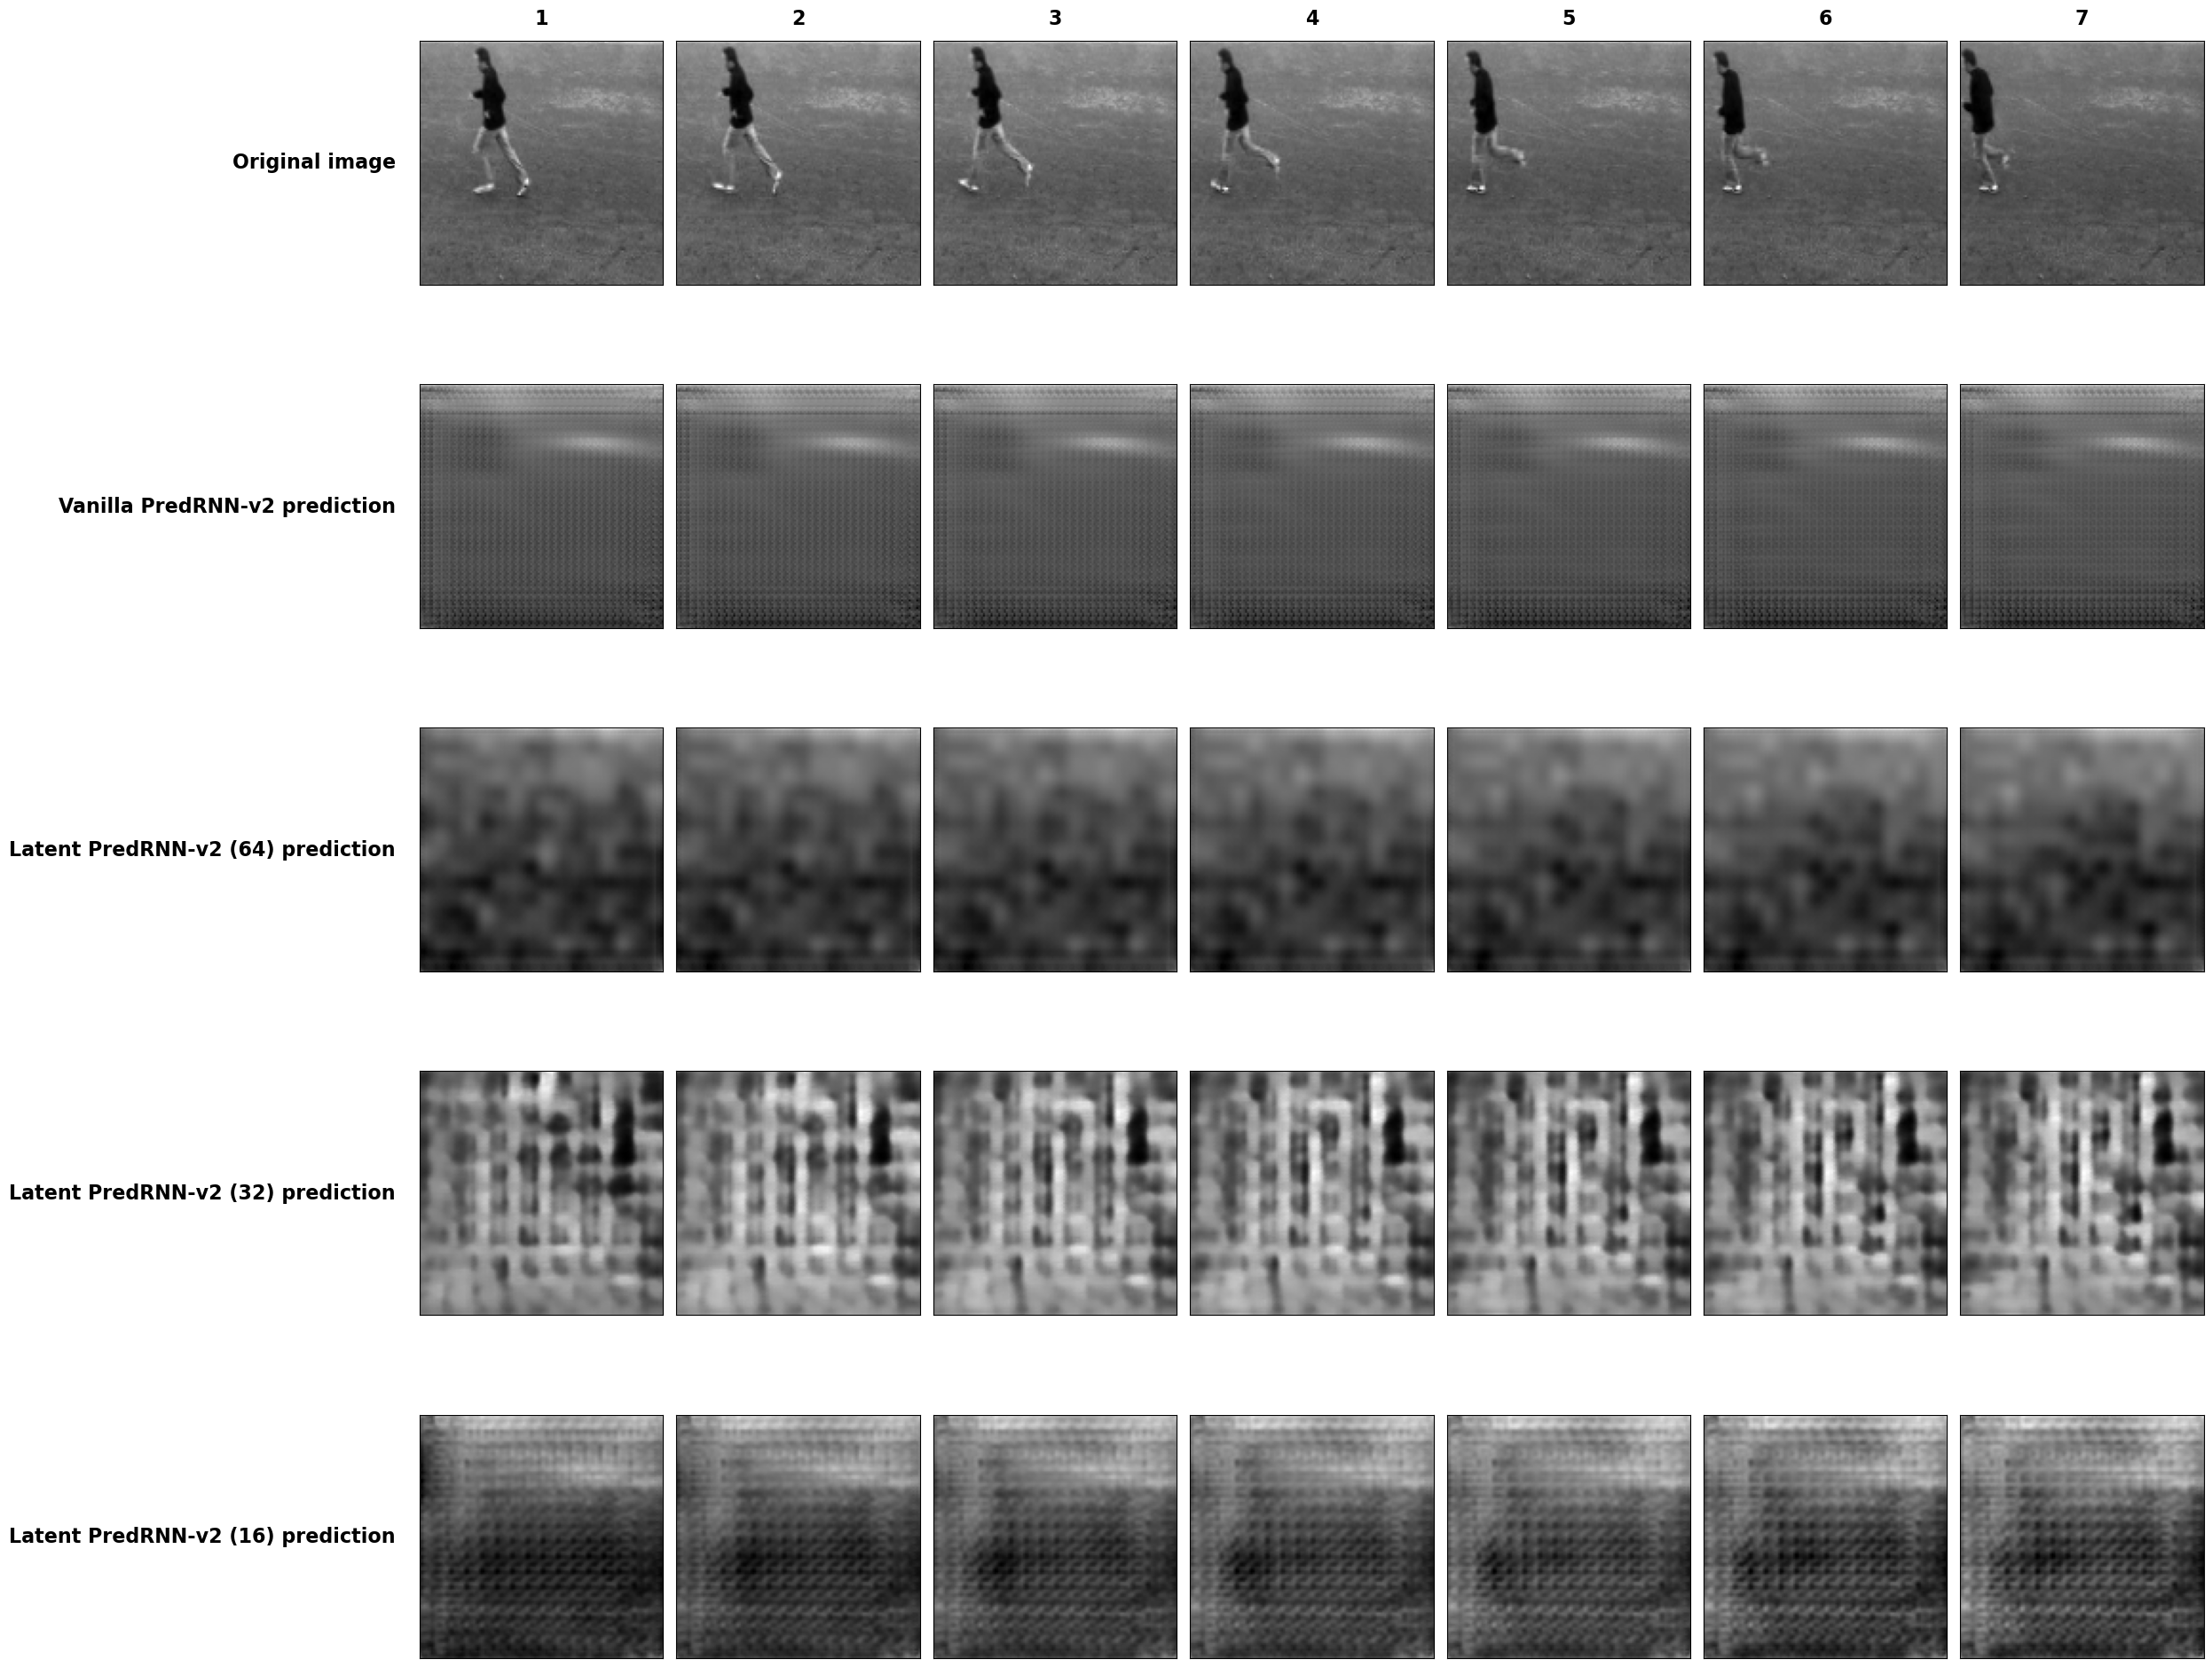

In [ ]:
n_sequences = 5
n_images = 7

image_labels = ['input', 'vanilla', 64, 32, 16]

fig, axes = plt.subplots(n_sequences, n_images, figsize=(25, 20))

# Timestep titles
for image_idx in range(n_images):
    axes[0, image_idx].text(0.5, 1.05, f'{image_idx + 1}', 
                             ha='center', va='bottom', 
                             fontsize=16, fontweight='bold', 
                             transform=axes[0, image_idx].transAxes)

# Sequence titles
titles = {
    'input': 'Original image',
    'vanilla': 'Vanilla PredRNN-v2 prediction',
    64: 'Latent PredRNN-v2 (64) prediction',
    32: 'Latent PredRNN-v2 (32) prediction',
    16: 'Latent PredRNN-v2 (16) prediction'
}
for sequence_idx, images_type in enumerate(image_labels):
    axes[sequence_idx, 0].text(-0.1, 0.5, titles[images_type], 
                                ha='right', va='center', 
                                fontsize=16, fontweight='bold', 
                                transform=axes[sequence_idx, 0].transAxes)

for sequence_idx, images_type in enumerate(images):

    for image_idx in range(7):
        axes[sequence_idx, image_idx].imshow(images[images_type][image_idx], cmap='gray')
        
        axes[sequence_idx, image_idx].set_xticks([])
        axes[sequence_idx, image_idx].set_yticks([])

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

### 5.2 Compute metrics

In [13]:
loss_fn_alex = lpips_lib.LPIPS(net='vgg')

def gather_metrics(predRNNModel: PredRNNModel, autoencoderModel: AutoencoderModel, test_handle, latent_dimension: int):
    """Gathers the average mse, lpip, psnr, and ssim per sequence timestep.

    Args:
        predRNNModel (PredRNNModel): The trained PredRNN model to gather the metrics from.
        autoencoderModel (AutoencoderModel): The trained autoencoder, if any.
        test_handle: The test handle that provides the test dataset.
        latent_dimension (int): The latent dimension of the autoencoder, and input size of the network. This is ignored if no autoencoder is used (in case of vanilla model)

    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): The mse, lpip, psnr, and ssim per timestep
    """
    test_handle.begin(do_shuffle=False)

    avg_mse = 0
    batch_id = 0
    img_mse, ssim, psnr = [], [], []
    lp = []

    for i in range(total_length - input_length):
        img_mse.append(0)
        ssim.append(0)
        psnr.append(0)
        lp.append(0)

    # Reverse schedule sampling #
    mask_input = 1

    real_input_flag = np.zeros(
        (batch_size,
            total_length - mask_input - 1,
            img_width // patch_size,
            img_width // patch_size,
            patch_size ** 2 * img_channel))

    real_input_flag[:, :input_length - 1, :, :] = 1.0
    #  #  #  #  #  # 

    while (test_handle.no_batch_left() == False):
        batch_id = batch_id + 1
        
        # Retrieve data
        test_ims = test_handle.get_batch()
        
        input = test_ims
        if autoencoderModel is not None:
            # Encode #
            reshaped_test_ims = test_ims.reshape(batch_size, total_length, 1, 128, 128)
            reshaped_test_ims = torch.from_numpy(reshaped_test_ims)

            encoded_test_ims = torch.stack(list(autoencoderModel.encode(sequence) for sequence in reshaped_test_ims))
            encoded_test_ims = encoded_test_ims.detach().numpy().reshape(batch_size, total_length, latent_dimension, latent_dimension, 1)
            input = encoded_test_ims
            #  #  #  #  #
        
        # Patch
        test_dat = preprocess.reshape_patch(input, patch_size)
        test_ims = test_ims[:, :, :, :, :img_channel]
        
        # Forwards
        img_gen = predRNNModel.test(test_dat, real_input_flag)
        
        # De-patch
        img_gen = preprocess.reshape_patch_back(img_gen, patch_size)
        
        output = img_gen
        if autoencoderModel is not None:
            # Decode #
            img_gen_reshaped = img_gen.reshape(batch_size, total_length-1, 1, latent_dimension, latent_dimension)
            img_gen_reshaped = torch.from_numpy(img_gen_reshaped)

            decoded_img_gen = torch.stack(list(autoencoderModel.decode(sequence) for sequence in img_gen_reshaped))
            decoded_img_gen = decoded_img_gen.detach().numpy().reshape(batch_size, total_length-1, 128, 128, 1)
            output = decoded_img_gen
            #  #  #  #  #

        output_length = total_length - input_length 
        img_out = output[:, -output_length:]

        # Compute metrics per frame
        for i in range(output_length):
            x = test_ims[:, i + input_length, :, :, :]
            gx = img_out[:, i, :, :, :]
            gx = np.maximum(gx, 0)
            gx = np.minimum(gx, 1)
            
            # MSE per frame
            mse = np.square(x - gx).sum()
            img_mse[i] += mse
            avg_mse += mse
            
            # cal lpips
            img_x = np.zeros([batch_size, 3, 128, 128])
            img_x[:, 0, :, :] = x[:, :, :, 0]
            img_x[:, 1, :, :] = x[:, :, :, 0]
            img_x[:, 2, :, :] = x[:, :, :, 0]
            img_x = torch.FloatTensor(img_x)
            
            img_gx = np.zeros([batch_size, 3, 128, 128])
            img_gx[:, 0, :, :] = gx[:, :, :, 0]
            img_gx[:, 1, :, :] = gx[:, :, :, 0]
            img_gx[:, 2, :, :] = gx[:, :, :, 0]
            img_gx = torch.FloatTensor(img_gx)
            lp_loss = loss_fn_alex(img_x, img_gx)
            lp[i] += torch.mean(lp_loss).item()

            real_frm = np.uint8(x * 255)
            pred_frm = np.uint8(gx * 255)

            psnr[i] += metrics.batch_psnr(pred_frm, real_frm)
            
            for b in range(batch_size):
                score, _ = compare_ssim(pred_frm[b], real_frm[b], full=True, channel_axis=2)
                ssim[i] += score

        test_handle.next()
        if batch_id == 3:
            break
        
        img_mse = np.array(img_mse) / (batch_id * batch_size)
        lp = np.array(lp) / (batch_id * batch_size)
        psnr = np.array(psnr) / batch_id
        ssim = np.array(ssim) / batch_id
    
    return img_mse, lp, psnr, ssim
    
# mse, lp, psnr, ssim = gather_metrics(predrnn, autoencoder, test_handle)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
test_handle = load_test_dataset(None, predrnn_base_data_dir)

results = {}

# Test Vanilla #
img_width = 128

predrnn = load_predRNN(None, predrnn_root_path, predrnn_base_data_dir)

mse, lp, psnr, ssim = gather_metrics(predrnn, None, test_handle, None)
results['vanilla'] = {
    'mse': mse,
    'lp': lp,
    'psnr': psnr,
    'ssim': ssim
}
# # # # # # # # #

# Test Latent models #
for latent in [16, 32, 64]:
    img_width = latent

    autoencoder = load_autoencoder(latent, autoencoder_root_path)
    predrnn = load_predRNN(latent, predrnn_root_path, predrnn_base_data_dir)
    
    mse, lp, psnr, ssim = gather_metrics(predrnn, autoencoder, test_handle, latent)
    
    model_results = {
        'mse': mse,
        'lp': lp,
        'psnr': psnr,
        'ssim': ssim
    }
    
    results[latent] = model_results

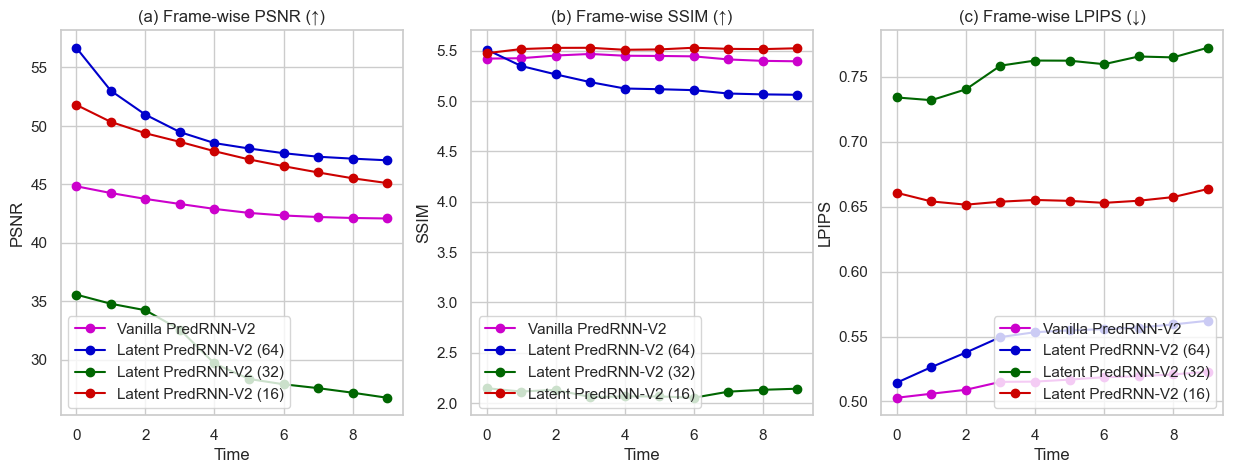

In [ ]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,5))

# PSNR #
plt.subplot(1, 3, 1)
plt.plot(range(len(results['vanilla']['psnr'])), results['vanilla']['psnr'], marker='o', color='#cc01cc', label='Vanilla PredRNN-V2')
plt.plot(range(len(results[64]['psnr'])), results[64]['psnr'], marker='o', color='#0000cc', label='Latent PredRNN-V2 (64)')
plt.plot(range(len(results[32]['psnr'])), results[32]['psnr'], marker='o', color='#006601', label='Latent PredRNN-V2 (32)')
plt.plot(range(len(results[16]['psnr'])), results[16]['psnr'], marker='o', color='#cc0100', label='Latent PredRNN-V2 (16)')

plt.title('(a) Frame-wise PSNR (↑)')
plt.xlabel('Time')
plt.ylabel('PSNR')

plt.legend(loc='lower left')

# SSIM #
plt.subplot(1, 3, 2)
plt.plot(range(len(results['vanilla']['ssim'])), results['vanilla']['ssim'], marker='o', color='#cc01cc', label='Vanilla PredRNN-V2')
plt.plot(range(len(results[64]['ssim'])), results[64]['ssim'], marker='o', color='#0000cc', label='Latent PredRNN-V2 (64)')
plt.plot(range(len(results[32]['ssim'])), results[32]['ssim'], marker='o', color='#006601', label='Latent PredRNN-V2 (32)')
plt.plot(range(len(results[16]['ssim'])), results[16]['ssim'], marker='o', color='#cc0100', label='Latent PredRNN-V2 (16)')

plt.title('(b) Frame-wise SSIM (↑)')
plt.xlabel('Time')
plt.ylabel('SSIM')

plt.legend(loc='lower left')

# LPIPS #
plt.subplot(1, 3, 3)
plt.plot(range(len(results['vanilla']['lp'])), results['vanilla']['lp'], marker='o', color='#cc01cc', label='Vanilla PredRNN-V2')
plt.plot(range(len(results[64]['lp'])), results[64]['lp'], marker='o', color='#0000cc', label='Latent PredRNN-V2 (64)')
plt.plot(range(len(results[32]['lp'])), results[32]['lp'], marker='o', color='#006601', label='Latent PredRNN-V2 (32)')
plt.plot(range(len(results[16]['lp'])), results[16]['lp'], marker='o', color='#cc0100', label='Latent PredRNN-V2 (16)')

plt.title('(c) Frame-wise LPIPS (↓)')
plt.xlabel('Time')
plt.ylabel('LPIPS')

plt.legend(loc='lower right')

plt.show()
plt.clf()
plt.close()

### 5.3 Time consumption

In [18]:
def time_model(predRNNModel: PredRNNModel, autoencoderModel: AutoencoderModel, test_handle, latent_dimension: int):
    """Gathers information about how long the model takes to pass an evaluation epoch.

    Args:
        predRNNModel (PredRNNModel): The trained PredRNN model to gather the metrics from.
        autoencoderModel (AutoencoderModel): The trained autoencoder, if any.
        test_handle: The test handle that provides the test dataset.
        latent_dimension (int): The latent dimension of the autoencoder, and input size of the network. This is ignored if no autoencoder is used (in case of vanilla model)

    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): The mse, lpip, psnr, and ssim per timestep
    """
    test_handle.begin(do_shuffle=False)
    
    batch_times = []
    encode_times = []
    decode_times = []
    inference_times = []
    
    epoch_start = time.time()

    # Reverse schedule sampling #
    mask_input = 1

    real_input_flag = np.zeros(
        (batch_size,
            total_length - mask_input - 1,
            img_width // patch_size,
            img_width // patch_size,
            patch_size ** 2 * img_channel))

    real_input_flag[:, :input_length - 1, :, :] = 1.0
    #  #  #  #  #  # 

    i = 0
    while (test_handle.no_batch_left() == False):
        i = i+1
        batch_start = time.time()
        
        # Retrieve data
        test_ims = test_handle.get_batch()
        
        input = test_ims
        
        encode_start = time.time()
        if autoencoderModel is not None:
            # Encode #
            reshaped_test_ims = test_ims.reshape(batch_size, total_length, 1, 128, 128)
            reshaped_test_ims = torch.from_numpy(reshaped_test_ims)

            encoded_test_ims = torch.stack(list(autoencoderModel.encode(sequence) for sequence in reshaped_test_ims))
            encoded_test_ims = encoded_test_ims.detach().numpy().reshape(batch_size, total_length, latent_dimension, latent_dimension, 1)
            input = encoded_test_ims
            #  #  #  #  #
        encode_end = time.time()
        
        # Patch
        test_dat = preprocess.reshape_patch(input, patch_size)
        test_ims = test_ims[:, :, :, :, :img_channel]
        
        # Forwards
        inference_start = time.time()
        img_gen = predRNNModel.test(test_dat, real_input_flag)
        inference_end = time.time()
        
        # De-patch
        img_gen = preprocess.reshape_patch_back(img_gen, patch_size)
        
        output = img_gen
        decode_start = time.time()
        if autoencoderModel is not None:
            # Decode #
            img_gen_reshaped = img_gen.reshape(batch_size, total_length-1, 1, latent_dimension, latent_dimension)
            img_gen_reshaped = torch.from_numpy(img_gen_reshaped)

            decoded_img_gen = torch.stack(list(autoencoderModel.decode(sequence) for sequence in img_gen_reshaped))
            decoded_img_gen = decoded_img_gen.detach().numpy().reshape(batch_size, total_length-1, 128, 128, 1)
            output = decoded_img_gen
            #  #  #  #  #
        decode_end = time.time()
        batch_end = time.time()
        
        batch_time = batch_end - batch_start
        encode_time = encode_end - encode_start
        decode_time = decode_end - decode_start
        inference_time = inference_end - inference_start
        
        batch_times.append(batch_time)
        encode_times.append(encode_time)
        decode_times.append(decode_time)
        inference_times.append(inference_time)
        
        if i >= 5:
            break
        
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    
    return epoch_time, batch_times, inference_times, encode_times, decode_times


In [39]:
test_handle = load_test_dataset(None, predrnn_base_data_dir)

time_results = {}

# Test Vanilla #
img_width = 128

predrnn = load_predRNN(None, predrnn_root_path, predrnn_base_data_dir)

total, batched, inference, encode, decode = time_model(predrnn, None, test_handle, None)
time_results['vanilla'] = {
    'total': np.array(total) * 1000,
    'batched': np.array(batched) * 1000,
    'inference': np.array(inference) * 1000,
    'encode': np.array(encode) * 1000,
    'decode': np.array(decode) * 1000
}
# # # # # # # # #

# Test Latent models #
for latent in [64, 32, 16]:
    img_width = latent

    autoencoder = load_autoencoder(latent, autoencoder_root_path)
    predrnn = load_predRNN(latent, predrnn_root_path, predrnn_base_data_dir)
    
    total, batched, inference, encode, decode = time_model(predrnn, autoencoder, test_handle, latent)
    
    model_results = {
        'total': np.array(total) * 1000,
        'batched': np.array(batched) * 1000,
        'inference': np.array(inference) * 1000,
        'encode': np.array(encode) * 1000,
        'decode': np.array(decode) * 1000
    }
    
    time_results[latent] = model_results

begin load data/Users/maxneerken/Documents/aml/predrnn-pytorch-AML/dataset/kth
Preparing to load 13094 video frames.
there are 13094 pictures
there are 4147 sequences
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_vanilla/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_64/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_32/best.model
load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_16/best.model


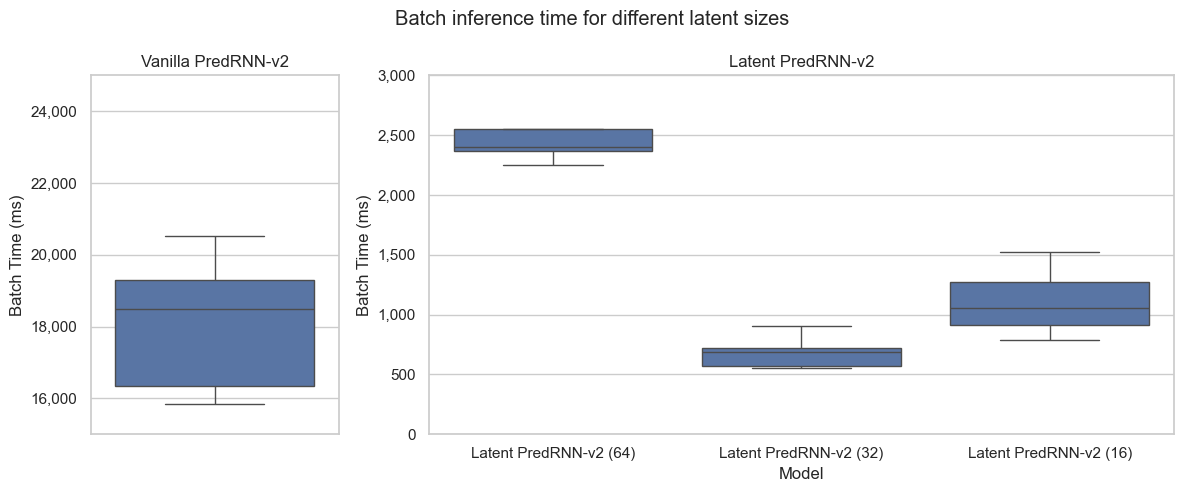

In [ ]:
latent_models = [
    ('Latent PredRNN-v2 (64)', 64),
    ('Latent PredRNN-v2 (32)', 32),
    ('Latent PredRNN-v2 (16)', 16)
]

sns.set_theme(style='whitegrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 3])

axs[0].set_title('Vanilla PredRNN-v2', fontsize=12)
axs[0].set_ylabel('Batch Time (ms)')
sns.boxplot(data=time_results['vanilla']['batched'], ax=axs[0]) #, color='#cc01cc')
    
latent_df = pd.DataFrame()
for display_name, internal_name in latent_models:
    # Add the batch times to the DataFrame
    latent_df = pd.concat([latent_df, pd.DataFrame({
        'Model': display_name,
        'Batch Time (ms)': time_results[internal_name]['batched']
    })])
    
sns.boxplot(x='Model', y='Batch Time (ms)', data=latent_df, ax=axs[1]) #, palette=['#0000cc', '#006601', '#cc0100'])
axs[1].set_title('Latent PredRNN-v2', fontsize=12)

# axs[1].plot([], c='#0000cc', label='Latent PredRNN-v2 (64)')
# axs[1].plot([], c='#006601', label='Latent PredRNN-v2 (32)')
# axs[1].plot([], c='#cc0100', label='Latent PredRNN-v2 (16)')
# axs[1].legend()

# Adjust y axis
axs[0].set_ylim(15000, 25000)
axs[1].set_ylim(0, 3000)

for ax in axs:
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.suptitle('Batch inference time for different latent sizes')
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

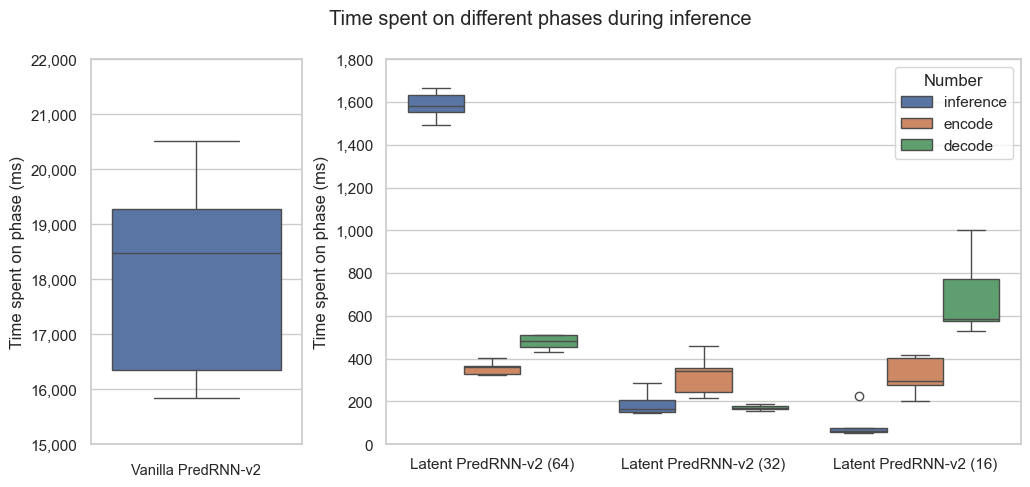

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

models = [
    ('Vanilla PredRNN-v2', 'vanilla'),
    ('Latent PredRNN-v2 (64)', 64),
    ('Latent PredRNN-v2 (32)', 32),
    ('Latent PredRNN-v2 (16)', 16)
]

np.random.seed(44)

time_vanilla = pd.DataFrame(time_results['vanilla'])[['inference', 'encode', 'decode']].assign(Model='Vanilla PredRNN-v2').rename({'inference': 'Inference'})

time_64 = pd.DataFrame(time_results[64])[['inference', 'encode', 'decode']].assign(Model='Latent PredRNN-v2 (64)')
time_32 = pd.DataFrame(time_results[32])[['inference', 'encode', 'decode']].assign(Model='Latent PredRNN-v2 (32)')
time_16 = pd.DataFrame(time_results[16])[['inference', 'encode', 'decode']].assign(Model='Latent PredRNN-v2 (16)')
time_latent = pd.concat([time_64, time_32, time_16]).rename({
    'inference': 'Inference',
    'encode': 'Encode',
    'decode': 'Decode'
    })
melted_latent = pd.melt(time_latent, id_vars=['Model'], var_name='Number')

fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 3])

# Vanilla
sns.boxplot(time_vanilla['inference'], ax=axs[0])
axs[0].set_ylabel('Time spent on phase (ms)')  
axs[0].set_xlabel('Vanilla PredRNN-v2', fontsize=10.5)  

# Latent
sns.boxplot(x="Model", y="value", hue="Number", data=melted_latent, ax=axs[1])
axs[1].set_ylabel('Time spent on phase (ms)')  
axs[1].set_xlabel('')  

# Adjust y axis
axs[0].set_ylim(15000, 22000)
axs[1].set_ylim(0, 1800)

for ax in axs:
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.suptitle('Time spent on different phases during inference')
plt.show()
plt.clf()
plt.close()

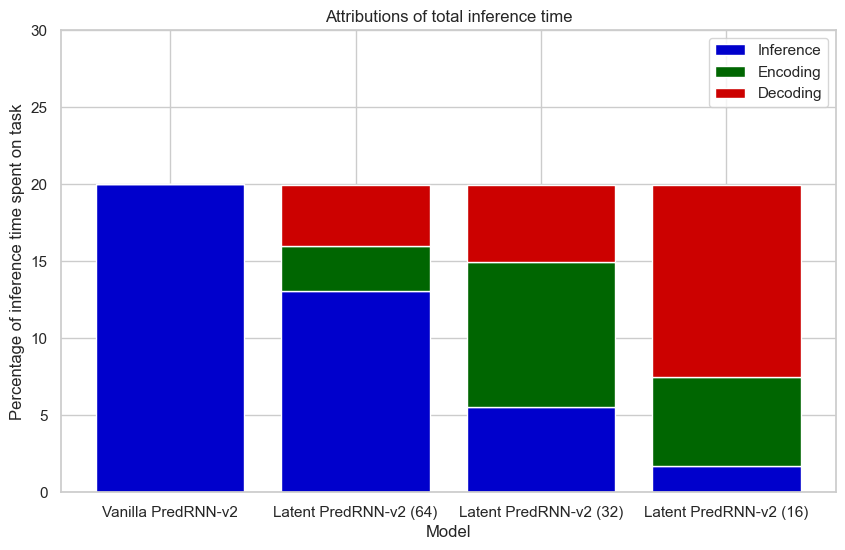

In [ ]:

models = [
    ('Vanilla PredRNN-v2', 'vanilla'),
    ('Latent PredRNN-v2 (64)', 64),
    ('Latent PredRNN-v2 (32)', 32),
    ('Latent PredRNN-v2 (16)', 16)
]

display_names = list(display_name for (display_name, internal_name) in models)
inference_attributions = []
encode_attributions = []
decode_attributions = []

for i, (display_name, internal_name) in enumerate(models):
    model_results = time_results[internal_name]
    
    inference_portion = np.mean(model_results['inference'] / model_results['total']) * 100
    encode_portion = np.mean(model_results['encode'] / model_results['total']) * 100
    decode_portion = np.mean(model_results['decode'] / model_results['total']) * 100
    
    inference_attributions.append(inference_portion)
    encode_attributions.append(encode_portion)
    decode_attributions.append(decode_portion)

sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 6))

plt.bar(display_names, inference_attributions, color='#0000cc', label='Inference')
plt.bar(display_names, encode_attributions, color='#006601', label='Encoding', bottom=inference_attributions)
plt.bar(display_names, decode_attributions, color='#cc0100', label='Decoding', bottom=np.array(inference_attributions)+np.array(encode_attributions))

ax = plt.gca()
ax.set_ylim([0, 30])

plt.title('Attributions of total inference time')
plt.xlabel('Model')
plt.ylabel('Percentage of inference time spent on task')
plt.legend()

plt.show()
plt.clf()
plt.close()
    

### 5.4 Parameters & FLOPS

In [ ]:
# N params


4.983832120895386